# LSTM model for Emotion Detection on labeled CMU Panoptic dataset
The LSTM model has 30 states in this script, corresponding to the 30 frames within one second.

## Input
trainX : 3-d array with shape: (# of seconds in total, # of frames/states, dimension of features)

e.g. in office1 should be (5346,30,76)

trainy : 1-d array with shape: (# of seconds in total,1)

## Output

Evaluation metrics and runtime spent on fitting

## Multipule persons
Notice, the LSTM model here is only for single person. 
The task for multiple person detection is conducted by openpose.

So, in the training stage, even if there are multiple persons in one sequence, we split them apart and train the LSTM respectively. 
Different persons' skeletons are a kind of data augmentation here.

While in the demo stage, we will assign each person emerging in the camera one LSTM. 

## Questions left
Why there are 2 persons in office2? Person 2's frames count is 1211?

# LET'S GO!

In [1]:
import os
import json
from time import time
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.models import model_from_json
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.
/home/ytian/.conda/envs/ytianpy36gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ytian/.conda/envs/ytianpy36gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ytian/.conda/envs/ytianpy36gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ytian/.c

In [2]:
%autosave 10
%matplotlib inline


Autosaving every 10 seconds


# 1. Define function for preparing the X and y for LSTM training and validation

In [3]:
'''
### X 
type: np.ndarray
shape: (# of samples, fps, 76)

### y 
type: list
shape: (# of samples,1)

The calibrated skeletons for each person are stored in :
../170915_office1/camerawise_skeleton/hd_0_0(0-30)_samples_for_persons.json

'''
def prepare_X_y(label_name,data_path,seq_name):
    

    # Load the skeletons from different cameras
    cameras_skeletons_list=list()
    json_files = [pos_json for pos_json in os.listdir(data_path+seq_name+"/camerawise_skeleton/") if pos_json.endswith('.json')]

    for index, js in enumerate(json_files):
        try:
            with open(os.path.join(data_path+seq_name+"/camerawise_skeleton/", js)) as json_file:
                skeletons = json.load(json_file)
            cameras_skeletons_list.append(skeletons)
        except IOError as e:
            print('Error reading {0}\n'.format(skel_json_fname)+e.strerror) 
    
#     print("# of cameras:",len(cameras_skeletons_list))
    
    # Load the labels
    df = pd.read_excel (data_path+seq_name+label_name)
    # office1:(84,3); office2 :(36,3)  
    # ndarray ([start_frame, end_frame),label), second wise label
    labels=df.as_matrix()
    
        
    if seq_name=='170407_office2':
        labels=labels[:-4]
    secn=len(labels)
    
    ratio=int(fps/30)
    new_secn=int(secn/ratio)
    # adjust labels according to fps value        
    if fps > 30:
        

        
        # First , padding the labels to make it be able to be diveided by 2
        same_cnt=1
        last_label=labels[0][2]
        labels_padding=list()      
        labels_padding.append(labels[0])
        
        for idx in  range(1,secn):
            this_label=labels[idx][2]
            if this_label==last_label:
                labels_padding.append(labels[idx])
                same_cnt+=1
                last_label=this_label
            if this_label!=last_label and same_cnt %2 !=0:
                labels_padding.append([labels[idx-1][0],labels[idx-1][1],-1])
                labels_padding.append(labels[idx])                
                same_cnt=1
                last_label=this_label
            if this_label!=last_label and same_cnt %2 ==0:
                labels_padding.append(labels[idx])
                same_cnt=1
                last_label=this_label
        if same_cnt==1:
            labels_padding.append([labels[idx][0],labels[idx][1],-1])
        secn=len(labels_padding)
        new_secn=int(secn/ratio)
        
        labels_padding=np.array(labels_padding)
        print("shape of labels:", labels.shape,"shape of padding labels:", labels_padding.shape)
        print("num of 1 in labels:", sum(labels[:,2][np.where(labels[:,2]==1)]),"num of 2 in labels:",sum(labels[:,2][np.where(labels[:,2]==2)])/2, "num of 3 in labels:",sum(labels[:,2][np.where(labels[:,2]==3)])/3)
        print("num of 1 in labels_padding:", sum(labels_padding[:,2][np.where(labels_padding[:,2]==1)]),"num of 2 in labels_padding:",sum(labels_padding[:,2][np.where(labels_padding[:,2]==2)])/2, "num of 3 in labels_padding:",sum(labels_padding[:,2][np.where(labels_padding[:,2]==3)])/3)
        print(labels)
        print(labels_padding)
        labels=labels_padding
                
    new_labels=np.zeros((new_secn,3))    
    for sec in range(new_secn):
        start_sec=ratio*sec
        start=labels[start_sec][0]
        end=labels[start_sec+1][1]
        label1=labels[start_sec][2]
        label2=labels[start_sec+1][2]# might be -1
        new_label=label1

        new_labels[sec][0]=start
        new_labels[sec][1]=end
        new_labels[sec][2]=new_label
#         labels=new_labels
#         labels.astype(int)
        new_labels=new_labels.astype(int)
    
    start_frame=labels[:,0]
    end_frame=labels[:,1]
    label=labels[:,2]
    
    person_trainX=dict()
    for skeletons in cameras_skeletons_list:#31 cameras
        for person, skels in skeletons.items():
            filtered_skels=list()
            cnt=0
            for sec in range(len(labels_padding)):
                
                
                startfrm=int(start_frame[sec])
                endfrm=int(end_frame[sec])
                res=30-(endfrm-startfrm)
#                 if endfrm-startfrm < fps:
#                 print("res:",res)
                if res > 0 :
        
                    endfrm+=res
                if label[sec]!=-1:                    
                    for f in range(startfrm,endfrm):
                        filtered_skels.append(skels[str(f)])
                else:
                    for f in range(startfrm,endfrm):
                        filtered_skels.append([0 for i in range(76)])

#             print(len(filtered_skels))#2524 for padding
#             set_trace()
            if person not in person_trainX.keys():
                
                person_trainX[person]=list()
                
                person_trainX[person].extend(filtered_skels)
            else:
                person_trainX[person].extend(filtered_skels)

            
            
            
            
            

    # Convert the skeletons list into ndarray         
    for person, samples in person_trainX.items():
        # person_trainX[person] store the X
        person_trainX[person]=np.array(person_trainX[person]).reshape((-1,fps,76))

    # Extend emotion labels for 31 cameras 
    y_list=list()
    [y_list.extend(new_labels[:,2]) for i in range(31)]



    # Get the X and y for next step
    X=person_trainX['0']
    # of samples = 31 * len(frames_indices)
#     y=to_categorical(np.array(y_list))# keras one-hot classification label vector
   
    return X,y_list


# 2. Define function for 10-fold Cross-Validation for LSTM
**1)** We will define the model as having a single LSTM hidden layer.

LSTM(hidden_nodes, input_shape=(timesteps, input_dim))

hidden_nodes = This is the number of neurons of the LSTM. 
If you have a higher number, the network gets more powerful. 
Howevery, the number of parameters to learn also rises. 
This means it needs more time to train the network.

timesteps = the number of timesteps you want to consider. 
E.g. if you want to classify a sentence, this would be the number of words in a sentence.

input_dim = the dimensions of your features/embeddings. 
E.g. a vector representation of the words in the sentence

**2)** This is followed by a dropout layer intended to reduce overfitting of the model to the training data.

**3)** Finally, a dense fully connected layer is used to interpret the features extracted by the LSTM hidden layer, before a final output layer is used to make predictions.

**4)** The efficient Adam version of stochastic gradient descent will be used to optimize the network, and the categorical cross entropy loss function will be used given that we are learning a multi-class classification problem.

In [4]:
def LSTM_cv(folds,verbose, epochs, batch_size,X,y_list,y,level_2_dirname_acc,level_2_dirname_loss):    
    print("Start Cross Validation")
    # Define 10-fold cross validation test harness
    seed=7
    kfold = StratifiedKFold(folds, shuffle=True, random_state=seed)
    cvscores = []
    cvtime=[]
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    cv=1
    show_model = True
    # 10 Fold CV for LSTM
#     print(X.shape)
#     print("Start kfold")
    misclassification_skeletons_indices_whole_dataset_folds=list()
    mis_pred_res_folds=list()
    for train, test in kfold.split(X, y_list):    
        # LSTM model
        # The output for the model will be a three-element vector containing the probability of a given second belonging to each of the three emotion types.
        model = Sequential()
        model.add(CuDNNLSTM(78, 
                       return_sequences=True, 
                       input_shape=(n_timesteps,n_features)))
#         model.add(Dropout(0.2))
#         model.add(CuDNNLSTM(50, return_sequences=True))
        model.add(Dropout(0.08))
        model.add(CuDNNLSTM(58, return_sequences=True))
        model.add(Dropout(0.08))
        model.add(CuDNNLSTM(58))
        model.add(Dropout(0.08))
        model.add(Dense(58, activation='relu'))
        model.add(Dense(28, activation='relu'))
        model.add(Dense(8, activation='relu'))

        model.add(Dense(n_outputs, activation='softmax'))
        optimizer=Adam(lr=8e-5)
#         optimizer=Adam(lr=0.00000888, beta_1=0.9, beta_2=0.999, amsgrad=False)
#         optimizer=SGD(lr=0.00588)
        if show_model:
            print(model.summary())
            show_model = False
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#         print("compiled the model")
        # fit network
        t0 = time()
        print("started fitting")
        history=model.fit(X[train], to_categorical(np.array(y_list)[train]),validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=verbose)
#         print("finished fitting")
        t1 = time()
        
        
        
        
#         print("started eval")
        # evaluate model
        scores = model.evaluate(X[test], to_categorical(np.array(y_list)[test]), batch_size=batch_size, verbose=verbose)
#         print("finished eval")
                      
        # list all data in history
        print(history.history.keys())
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        plt.savefig(level_2_dirname_acc+"/fold"+str(cv)+'.png')
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        plt.savefig(level_2_dirname_loss+"/fold"+str(cv)+'.png')
        
        
        print("score from evaluate: %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))# model.metrics_names only have loss and acc
        
#       incorrects = np.nonzero(model.predict_classes(X[test]) != np.array(y_list)[test])
        pred_res = model.predict_classes(X[test])
        
        unravel_classification_true_false=pred_res==np.array(y_list)[test]
        unravel_classification_1_0=unravel_classification_true_false.astype(int)
        misclassification_indices=np.where(unravel_classification_1_0==0)[0]
        mis_pred_res=pred_res[misclassification_indices]
#         misclassification_skeletons=X[test][misclassification_indices]
        
        misclassification_skeletons_indices_whole_dataset=test[misclassification_indices]
        misclassification_skeletons_indices_whole_dataset_folds.append(misclassification_skeletons_indices_whole_dataset)
        mis_pred_res_folds.append(mis_pred_res)
        
        
#         set_trace()
#         print("misclassification vec:")
#         print(unravel_classification_1_0)
        print("score from predict_class vec:", sum(unravel_classification_1_0)/len(unravel_classification_1_0))         
        
        cvscores.append(scores[1] * 100)
        cvtime.append(t1-t0)
        cv+=1
    return cvscores,cvtime,misclassification_skeletons_indices_whole_dataset_folds,mis_pred_res_folds


# 3. Define function for project misclassification skeletons into images

In [5]:
def draw_skeletons(seconds_indices,mis_pred_res,X,y,level_2_dirname_FS,fold):
    X_mistakes=X[seconds_indices]
    y_mistakes=y[seconds_indices]
    body_edges = np.array([[1,2],[1,4],[4,5],
                           [5,6],[1,3],[3,7],
                           [7,8],[8,9],[3,13],
                           [13,14],[14,15],[1,10],
                           [10,11],[11,12]])-1
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.view_init(elev = -90, azim=-90)
#     ax.set_xlabel('X Label')
#     ax.set_ylabel('Y Label')
#     ax.set_zlabel('Z Label')
#     ax.axis('equal')
#     ax.set_aspect('equal')
    fold_path=level_2_dirname_FS+"/fold"+str(fold)
    if not os.path.exists(fold_path):
                os.makedirs(fold_path)
    for i, skels in enumerate(X_mistakes):
        sec=seconds_indices[i]
        true_label=y_mistakes[i]
        pred_label=mis_pred_res[i]
#         print("second order: ", sec)
#         print("misclassify label %d into %d" % (true_label,  pred_label))
#         if i>2:
#             break
        path_png=fold_path+"/sec"+str(sec)+"_label"+str(true_label)+"_into"+str(pred_label)
        for frame, skel in enumerate(skels): #30 consecutive frames
#             if frame>2:
#                 break
            
            fig = plt.figure()
            ax = fig.gca(projection='3d')
#                     ax.view_init(elev = -90, azim=-90)
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            skel = skel.reshape((-1,4)).transpose()

            for j,edge in enumerate(body_edges):
                ax.plot(skel[0,edge], skel[2,edge], -skel[1,edge])
            
            if not os.path.exists(path_png):
                os.makedirs(path_png)
            
            plt.savefig(path_png+"/frame"+str(frame)+".png")
                    

    

# Now Start LSTM !!

## Set up experiment parameters first

In [6]:
# Set up parameters
folds,verbose, epochs, batch_size=5,0,200000,500
label_num=3
fps=60

matplotlib_interaction_mode=0 # set this to 0 if you want background running
if matplotlib_interaction_mode==0:
    # Turn interactive plotting off
    plt.ioff()

## This cell makes dir to save the reult for every run on distinct timestamp

In [7]:
# get the start timestep for this experiment
dateTimeObj = datetime.now()
print("Current Time:")
print(dateTimeObj.year, '/', dateTimeObj.month, '/', dateTimeObj.day)
print(dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second, '.', dateTimeObj.microsecond)
timestamp=str(dateTimeObj.year)+'y'+str(dateTimeObj.month)+"m"+str(dateTimeObj.day)+"d"+str(dateTimeObj.hour)+"h"+str(dateTimeObj.minute)+"m"+str(dateTimeObj.second)+"s"
print("Experiment No.",timestamp)
print("PID:",os.getpid())

print("%d Labels Classification Task on Skeleton Emotion Detection" % (label_num))
print("Hyperparameters Setting: Folds %d , Verbose %d, Epochs %d, Batch_Size %d" % (folds,verbose, epochs, batch_size))



level_1_dirname="results/"+timestamp+"_"+str(label_num)+"classes"+"_"+str(folds)+"folds"+"_"+str(epochs)+"epochs"+"_"+str(batch_size)+"batchsize"
level_2_dirname_acc=level_1_dirname+"/accuracy"
level_2_dirname_loss=level_1_dirname+"/loss"
level_2_dirname_FS=level_1_dirname+"/FailedSkeletons"
# print(level_1_dirname)

# print (os.path.exists(level_1_dirname))

if not os.path.exists(level_1_dirname):
    os.makedirs(level_1_dirname)
    os.makedirs(level_2_dirname_acc)
    os.makedirs(level_2_dirname_loss)
    os.makedirs(level_2_dirname_FS)
else:
    if not os.path.exists(level_2_dirname_acc):
        os.makedirs(level_2_dirname_acc)
    if not os.path.exists(level_2_dirname_loss):
        os.makedirs(level_2_dirname_loss)
    if not os.path.exists(level_2_dirname_FS):
        os.makedirs(level_2_dirname_FS)
    

Current Time:
2019 / 11 / 19
17 : 5 : 17 . 699657
Experiment No. 2019y11m19d17h5m17s
PID: 18785
3 Labels Classification Task on Skeleton Emotion Detection
Hyperparameters Setting: Folds 5 , Verbose 0, Epochs 200000, Batch_Size 500


## This cell setups the paths for reading the datasets

In [8]:
# 
data_path = '../'
seq_name_1 = '170915_office1'#5376 samples in total
seq_name_2 = '170407_office2' #3649
label_name_office1= '/office1_relabel.xlsx'
label_name_office2= '/office2_relabel.xlsx'

camera_name='0' #could be 0-30
# hd_skel_json_path=data_path+seq_name+"/camerawise_skeleton/"


## This cell reads the datasets from office1 and office2 

In [9]:
# # Read the datasets from office1 and office2 

# hd_skel_json_path=data_path+seq_name+"/camerawise_skeleton/"
X1,y1_list=prepare_X_y(label_name_office1,data_path,seq_name_1)
X2,y2_list=prepare_X_y(label_name_office2,data_path,seq_name_2)

# Conbine office1 and office2
X=np.concatenate((X1, X2), axis=0)
y1_list.extend(y2_list)
y=to_categorical(np.array(y1_list))# keras one-hot classification label vector

def convert(o):
    if isinstance(o, np.int64): return int(o)  
    raise TypeError
np.save('X.npy',X)
np.save('y.npy',y)
with open('y1_list.json', 'w+') as outfile:
    json.dump(y1_list, outfile,default=convert)

/home/ytian/.conda/envs/ytianpy36gpu/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


shape of labels: (84, 3) shape of padding labels: (88, 3)
num of 1 in labels: 14 num of 2 in labels: 33.0 num of 3 in labels: 37.0
num of 1 in labels_padding: 14 num of 2 in labels_padding: 33.0 num of 3 in labels_padding: 37.0
[[ 210  240    3]
 [ 240  270    3]
 [ 420  450    3]
 [ 450  480    3]
 [ 480  509    3]
 [ 509  539    2]
 [ 539  569    2]
 [ 569  599    2]
 [ 599  629    2]
 [ 629  659    3]
 [ 659  689    3]
 [ 689  719    3]
 [ 719  749    3]
 [ 749  779    3]
 [ 779  809    3]
 [ 839  869    3]
 [ 869  899    3]
 [ 899  929    3]
 [ 929  959    3]
 [ 959  989    3]
 [ 989 1019    2]
 [1019 1049    2]
 [1049 1079    2]
 [1079 1109    2]
 [1109 1139    2]
 [1169 1199    2]
 [1199 1229    2]
 [1229 1259    2]
 [1379 1409    1]
 [1469 1499    1]
 [1499 1528    1]
 [1528 1558    1]
 [1558 1588    1]
 [1588 1618    1]
 [1618 1648    1]
 [1648 1678    1]
 [1738 1768    3]
 [1768 1798    3]
 [1798 1828    3]
 [1828 1858    3]
 [2068 2098    3]
 [2098 2128    3]
 [2128 2158    3

## This cell does the Data Preprocessing

In [10]:
'''
To make X skeletons' coordinates normalized or scaled
'''
X_copy=X

X_small_1=X
X_small_2=np.copy(X_small_1)
# X_small_cp=np.copy(X_small_1)
# Do the data preprocessing here


def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly."""
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

'''
X[:,:,:19].shape
(2387, 30, 76)
'''
joints=list()
for joint_no in range(19):
    joint=X[:,:,4*joint_no:4*(joint_no+1)]
    joints_coor=joint[:,:,:3]
    joints1=(joints_coor-np.mean(joints_coor))/np.std(joints_coor)
    joints2=rescale_linear(joints_coor,0,1)
    X_small_1[:,:,4*joint_no:4*(joint_no+1)-1]=joints1
    X_small_2[:,:,4*joint_no:4*(joint_no+1)-1]=joints2
np.save("scaled_X_0to1.npy",X_small_2)    
np.save("normamilzed_X.npy",X_small_1)


## This cell performs training and evaluation on LSTM by cross-validation 

Notice:

the "seconds" in "misclassification_seconds_indices_whole_dataset_folds" still not the real video's second

it's only the indices of X and y

still need work to map them back to the real timestamp

Start Cross Validation




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 60, 78)            48672     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 78)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 60, 58)            32016     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 58)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 58)                27376     
_________________________________________________________________
dropout_3 (Dropout)          (None, 58)                0         


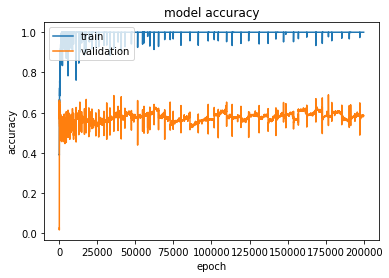

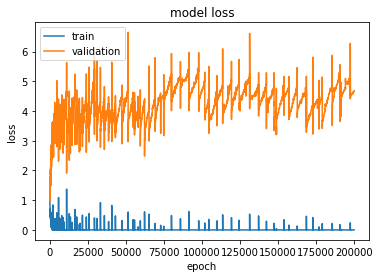

score from evaluate: acc: 80.40%
score from predict_class vec: 0.8040201005025126
started fitting
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


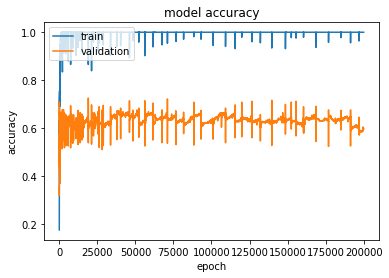

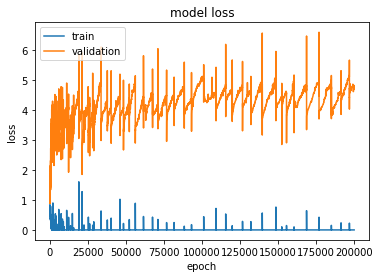

score from evaluate: acc: 86.93%
score from predict_class vec: 0.8693467336683417
started fitting
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


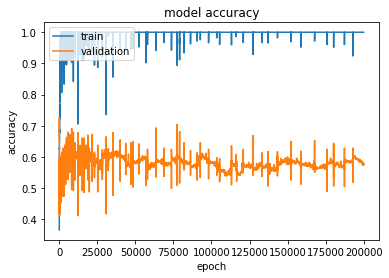

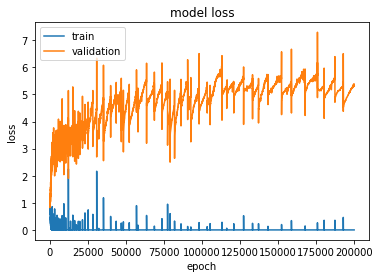

score from evaluate: acc: 82.32%
score from predict_class vec: 0.8232323232323232
started fitting
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


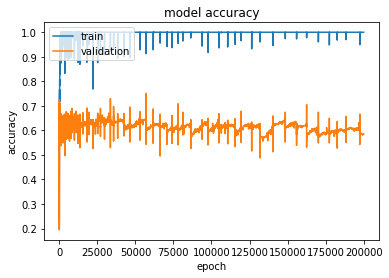

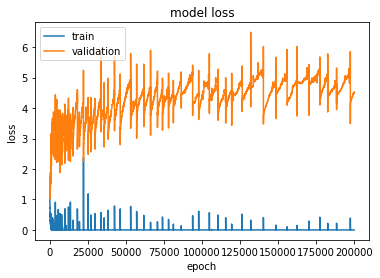

score from evaluate: acc: 83.08%
score from predict_class vec: 0.8308080808080808
started fitting
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


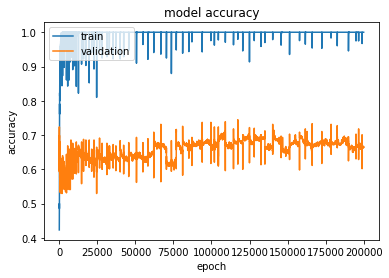

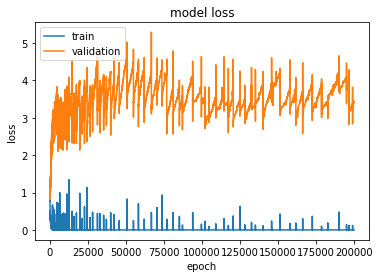

score from evaluate: acc: 87.63%
score from predict_class vec: 0.8762626262626263
misclassification skeletons for fold: 0


/home/ytian/.conda/envs/ytianpy36gpu/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


misclassification skeletons for fold: 1
misclassification skeletons for fold: 2
misclassification skeletons for fold: 3
misclassification skeletons for fold: 4
Average accuracy over %d folds:
84.07% (+/- 2.77%)
Average time spent on fitting for each cv with epoch=  200000, batchsize=  500 is:  14767.030548 seconds


In [11]:
# Load the dataset we want
X=np.load('X.npy')
X_scaled=np.load("scaled_X_0to1.npy")
X_normalized=np.load("normamilzed_X.npy")
y=np.load('y.npy')
y1 = np.array([yi[1:] for yi in y])
with open('y1_list.json') as infile:
    y1_list=json.load(infile)
y1_list = np.array(y1_list) - 1

X_list=[X_scaled,X_normalized]

# for X_preprocessed in X_list:
# Start trainning and testing LSTM and get results back
cvscores,cvtime,misclassification_seconds_indices_whole_dataset_folds,mis_pred_res_folds=LSTM_cv(folds,verbose, epochs, batch_size,X_normalized,y1_list,y1,level_2_dirname_acc,level_2_dirname_loss)

# Try to see which one is misclassified
for i, each_fold_misclassification_seconds in enumerate(misclassification_seconds_indices_whole_dataset_folds):
    print("misclassification skeletons for fold:", i)
    draw_skeletons(each_fold_misclassification_seconds,mis_pred_res_folds[i],X,y1_list,level_2_dirname_FS,i)


# Print out the result to console
print("Average accuracy over %d folds:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average time spent on fitting for each cv with epoch= % d, batchsize= % d is: % 8f seconds" % (epochs,batch_size,np.mean(cvtime)))

# Print out the result to txt
sample = open(level_1_dirname+'/avg_result_over_all_folds.txt', 'w+') 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)), file = sample) 
print("average time spent on fitting for each cv with epoch= % d, batchsize= % d is: % .8f seconds" % (epochs,batch_size,np.mean(cvtime)), file = sample)
sample.close() 




In [12]:
!git branch

  anan
  failure_cases
* framelevel_relabel
  master
